In [1]:
import torch
import torch.nn as nn
import torchvision

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce 940MX'

In [3]:
class Block(nn.Module):
  def __init__(self, in_cn, out_cn):
    super().__init__()
    #cada block te dos convolucions
    self.conv1 = nn.Conv2d(in_cn, out_cn, 3)
    self.conv2 = nn.Conv2d(out_cn, out_cn, 3)
    #definim la funció d'activació
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.relu(self.conv2(self.relu(self.conv1(x))))

In [4]:
class Encoder(nn.Module):
  #a chs passem les dimensions dels Blocks que tindrem
  def __init__(self, chs=(3,64,128,256,512,1024)):
    super().__init__()
    #creem una llista de mòduls amb els blocks,
    #les dimensions seràn i i i+1, sent aquestes valors de la llista chs
    self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs) - 1)])
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    ftrs = []
    #per cada Block de la llista
    for block in self.enc_blocks:
      #obtenim l'output
      x = block(x)
      #l'afegim a la llista ftrs
      ftrs.append(x)
      #reduïm dimensions
      x = self.pool(x)
    return ftrs

In [5]:
class Decoder(nn.Module):
  #a chs passem les dimensions dels Blocks que tindrem
  def __init__(self, chs = (1024, 512, 256, 128, 64)):
    super().__init__()
    self.chs = chs
    #definim les upconvs com una llista de up-convolucions que anirà tenint els 
    #inputs i outputs i i i+1 definits a chs
    self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs) - 1)])
    #creem una llista de mòduls amb els blocks,
    #les dimensions seràn i i i+1, sent aquestes valors de la llista chs
    self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs) - 1)])

  def forward(self, x, encoder_features):
    #per cada valor dels tamanys
    for i in range(len(self.chs) - 1):
      #fem la up-convolution corresponent
      x = self.upconvs[i](x)
      #retallem el marge dels resultats obtinguts per l'encoder
      # (buit per culpa de la convolució)
      enc_ftrs = self.crop(encoder_features[i], x)
      #concatenem el valor actual amb els features retallats anteriorment
      x = torch.cat([x, enc_ftrs], dim=1)
      #ho passem al Block corresponent del Decoder
      x = self.dec_blocks[i](x)
    return x
  
  def crop(self, enc_ftrs, x):
    #optenim l'altura i amplada de x
    _, _, H, W = x.shape
    #retallem
    enc_ftrs = torchvision.transforms.CenterCrop([H,W])(enc_ftrs)
    return enc_ftrs

In [6]:
class UNet(nn.Module):
  def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
    super().__init__()
    self.encoder = Encoder(enc_chs)
    self.decoder = Decoder(dec_chs)
    self.head = nn.Conv2d(dec_chs[-1], num_class, 1)
    self.retain_dim = retain_dim
    self.out_sz = out_sz

  def forward(self, x):
    enc_ftrs = self.encoder(x)
    out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
    out = self.head(out)
    if self.retain_dim:
      out = nn.functional.interpolate(out, self.out_sz)
    return out

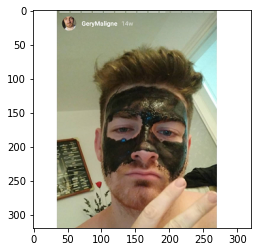

In [11]:
import cv2
import matplotlib.pyplot as plt

x = cv2.imread('match.png', cv2.IMREAD_COLOR)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
plt.imshow(x)

In [43]:
import numpy as np
convert = torchvision.transforms.ToTensor()

a = convert(x)

a.shape

torch.Size([3, 320, 320])

In [44]:
a = a[None,:]
a.shape

torch.Size([1, 3, 320, 320])

In [19]:
nx = torch.randn(1,3,572,572)
nx.shape

torch.Size([1, 3, 572, 572])

In [45]:
unet = UNet(retain_dim=True)
nx = torch.randn(1,3,572,572)
res = unet(a)
res.shape

C:\Users\ger-m\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 1, 572, 572])

In [65]:
a = res[0][0]

In [66]:
a = a.cpu().detach().numpy()

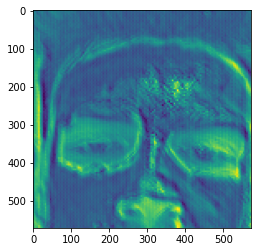

In [67]:
#a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(a)